In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Camera Calibration

Using the checkerboard images in camera_cal folder, compute camera matrix and distortion doefficients.

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'output_images/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(50)

cv2.destroyAllWindows()

Calibrate camera with cv2calibrateCamera(). Test on a test image using undistort.

Text(0.5, 1.0, 'Undistorted Image')

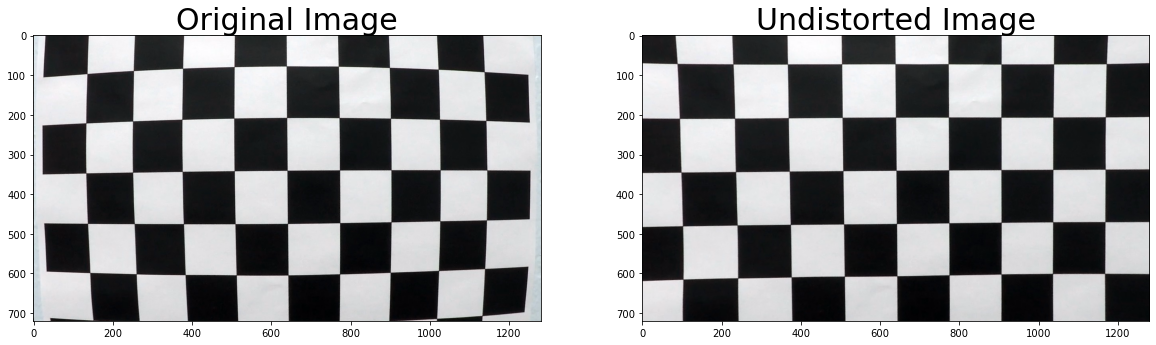

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('output_images/calibration1_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline (Test Images)

## Example of a distortion corrected image

In [4]:
def undst(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

Text(0.5, 1.0, 'Undistorted Image')

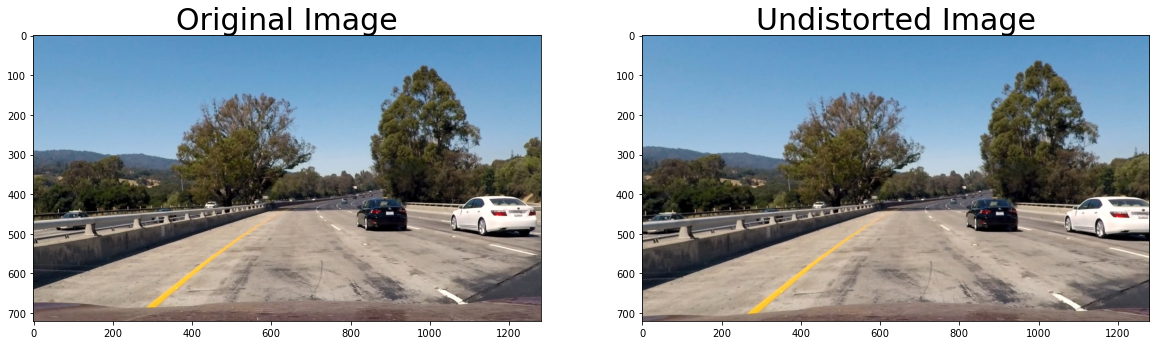

In [5]:
# img = cv2.imread('test_images/test2.jpg')
img = mpimg.imread('test_images/test1.jpg')
dst = undst(img, mtx, dist)
#cv2.imwrite('output_images/test2_undist.jpg', dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Note: Make sure you use the correct grayscale conversion depending on how you've read in your images. Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread(). Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().

## Binary image containing likely lane pixels using a method or combination of methods (i.e., color transforms, gradients)

### Define the functions we will use for gradients and color transforms.

Here we will define three sobel functions and then below we can experiment with parameters and combinations of these three function, sobel x or y, magnitude threshhold and direction threshold.

In [6]:
# function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
            
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        
    # 6) Return this mask as your binary_output image
        
    return binary_output

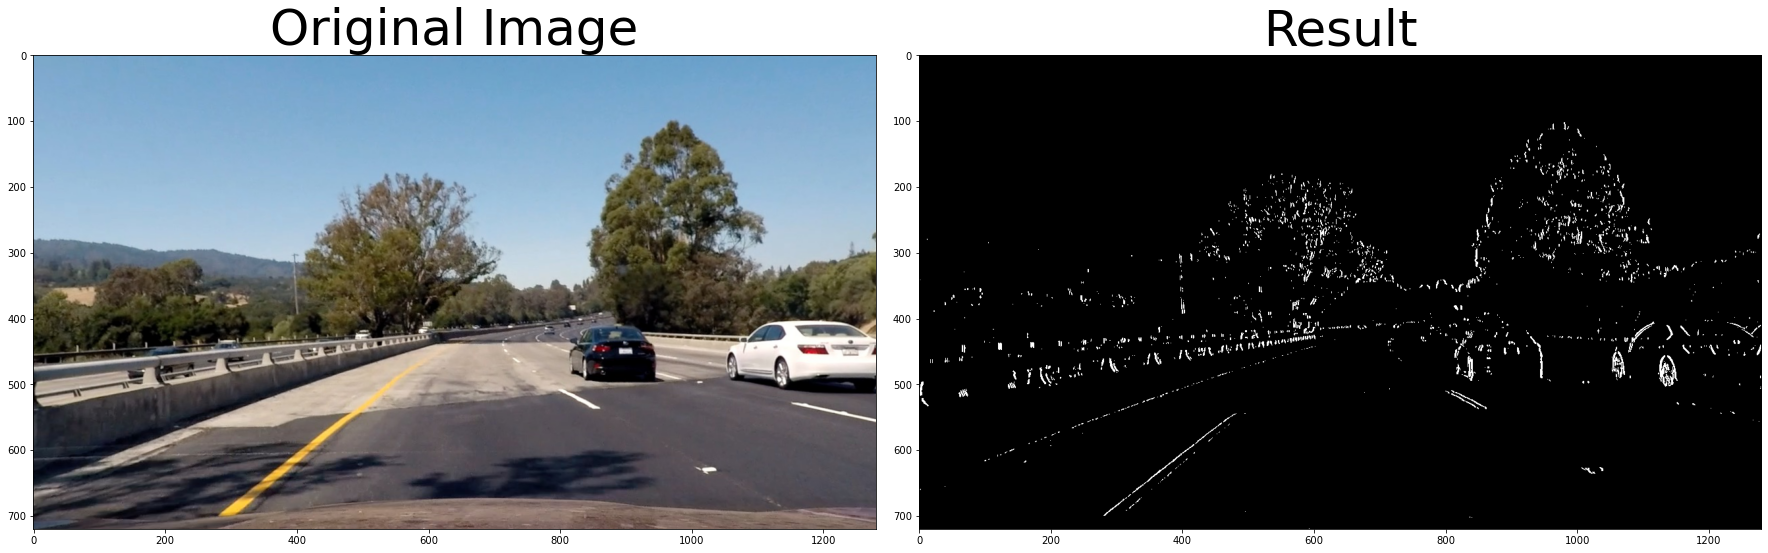

In [13]:
# Run the function
img = mpimg.imread('test_images/test4.jpg')
dst = undst(img, mtx, dist)
binary = abs_sobel_thresh(dst, orient='x', sobel_kernel=3, thresh=(50, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
# function that finds the magnatude of the gradient and applies a threshold

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 3) Calculate the magnitude
    abs_sobelxy = (sobelx**2 + sobely**2)**0.5
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

In [15]:
# function that finds the direction of the gradient and applies a threshold

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

In [16]:
# function that selects R, G or B and finds gradient and applies a treshold

def RGB_threshold(img, RGB='R', thresh = (200, 255)):
    
    # select color
    if RGB == 'R':
        img_color = img[:,:,0]
    if RGB == 'G':
        img_color = img[:,:,1]
    if RGB == 'B':
        img_color = img[:,:,2]
        
    # create a binary mask where R, G or B thresholds are met        
    binary_output = np.zeros_like(img_color)
    binary_output[(img_color >= thresh[0]) & (img_color <= thresh[1])] = 1
    
    # return this mask as your binary_output image
    return binary_output

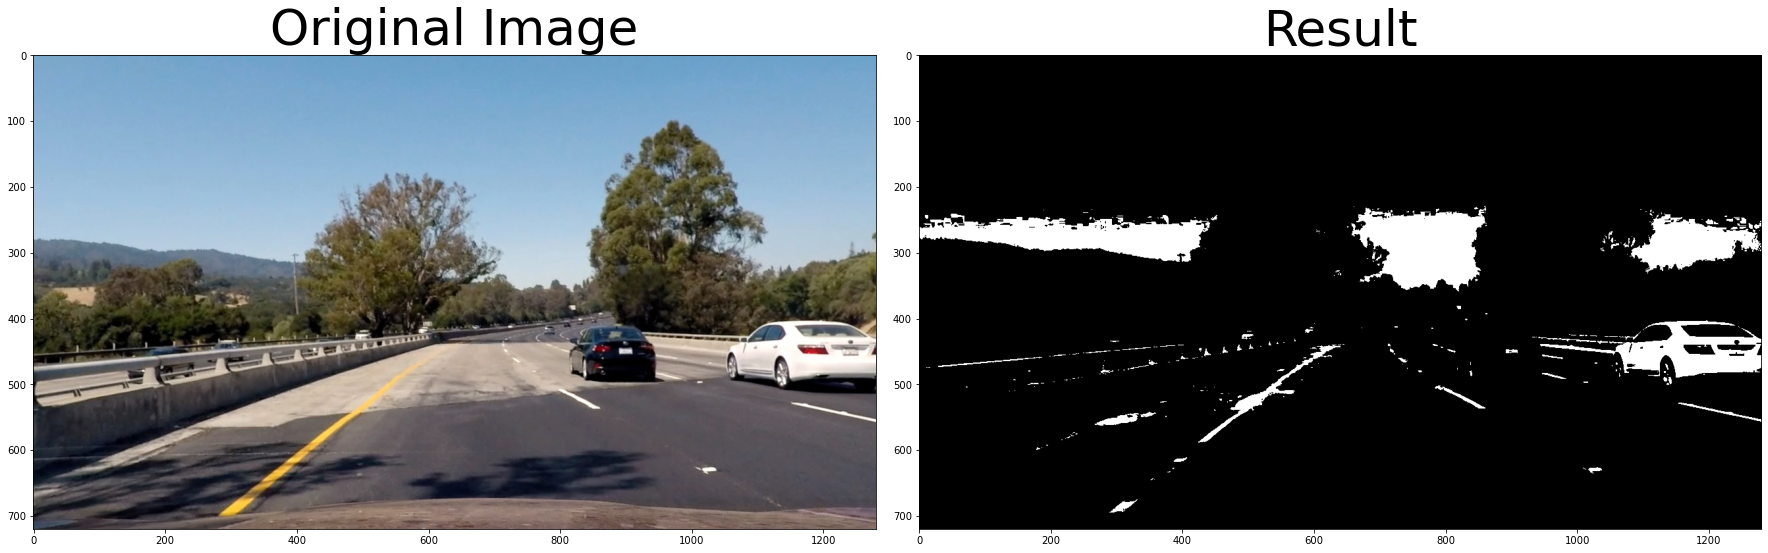

In [26]:
# Run the function
img = mpimg.imread('test_images/test4.jpg')
dst = undst(img, mtx, dist)
binary = RGB_threshold(dst, RGB='G', thresh=(200, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [18]:
# fucntion converts to HLS and selects H, L or S and finds gradient and applies a treshold

def HLS_threshold(img, HLS='S', thresh = (90, 255)):
    
    # convert to hls
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # select component
    if HLS == 'H':
        img_hls = hls[:,:,0]
        
    if HLS == 'L':
        img_hls = hls[:,:,1]
        
    if HLS == 'S':
        img_hls = hls[:,:,2]
        
    # create a binary mask where H, L or S thresholds are met
    binary_output = np.zeros_like(img_hls)
    binary_output[(img_hls >= thresh[0]) & (img_hls <= thresh[1])] = 1
    
    return binary_output

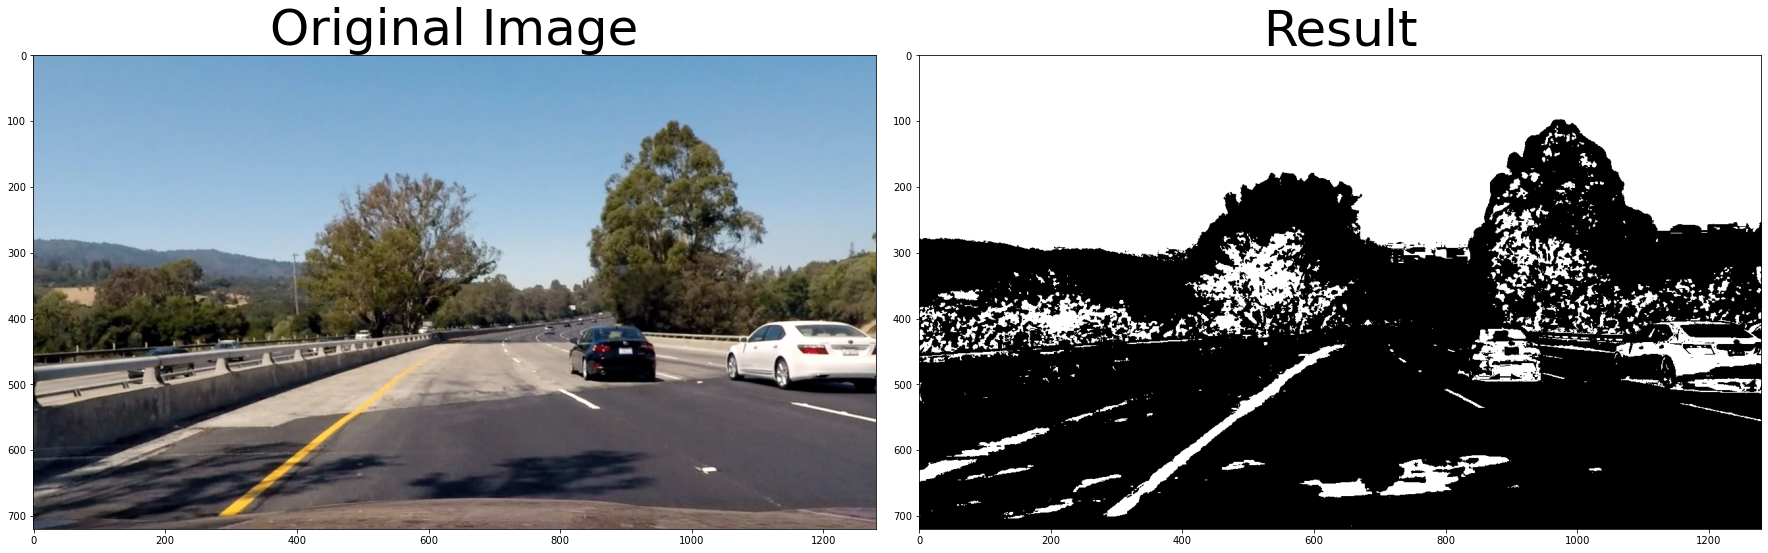

In [27]:
# Run the function
img = mpimg.imread('test_images/test4.jpg')
dst = undst(img, mtx, dist)
binary = HLS_threshold(dst, HLS='S', thresh=(90,255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# fucntion converts to HSV and selects H, S or V and finds gradient and applies a treshold

def HSV_threshold(img, HSV='S', thresh = (90, 255)):
    
    # convert to hls
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # select component
    if HSV == 'H':
        img_hsv = hsv[:,:,0]
        
    if HSV == 'S':
        img_hsv = hsv[:,:,1]
        
    if HSV == 'V':
        img_hsv = hsv[:,:,2]
        
    # create a binary mask where H, L or S thresholds are met
    binary_output = np.zeros_like(img_hsv)
    binary_output[(img_hsv >= thresh[0]) & (img_hsv <= thresh[1])] = 1
    
    return binary_output

In [ ]:
# Run the function
img = mpimg.imread('test_images/test4.jpg')
dst = undst(img, mtx, dist)
binary = HSV_threshold(dst, HSV='S', thresh=(90,255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary
    


In [ ]:
img = mpimg.imread('test_images/test4.jpg')
dst = undst(img, mtx, dist)

result = pipeline(dst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Read in an image
image = mpimg.imread('test_images/test4.jpg')
dst = undst(img, mtx, dist)

In [ ]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

In [ ]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

In [ ]:
combined = np.zeros_like(dir_binary)
combined[(gradx == 1) & ((mag_binary == 1) & (dir_binary == 1))] = 1

In [ ]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Here is example of binary image been created using gradients.  Below we will use and experiment with combinations of color transforms, gradients or other methods.

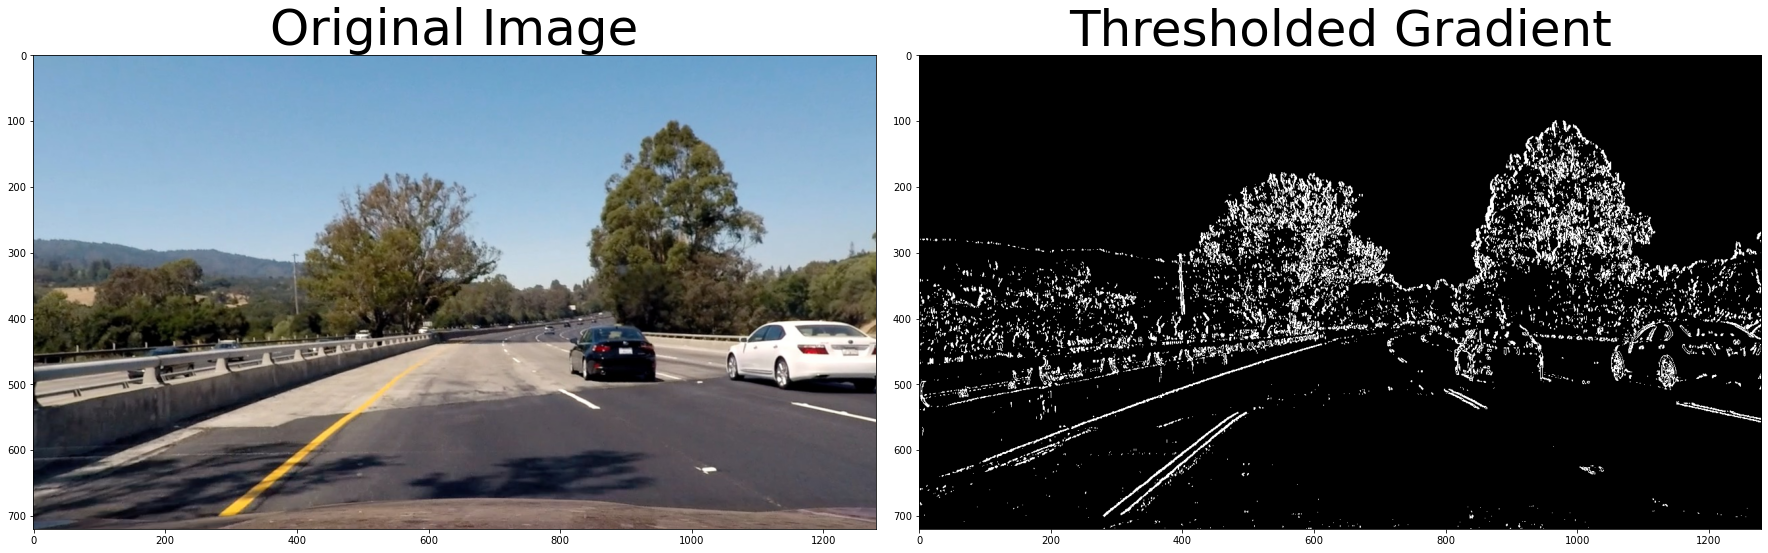

In [28]:
# Run the function
img = mpimg.imread('test_images/test4.jpg')
dst = undst(img, mtx, dist)
grad_binary = abs_sobel_thresh(dst, orient='x', sobel_kernel=3, thresh=(20,100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Now we can look at color tranforms

In [ ]:
# Make a list of test images
images_straight = glob.glob('test_images/straight_lines*.jpg')
images_test = glob.glob('test_images/test*.jpg')
#images = images_straight + images_test


# Video Pipeline

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  